In [1]:
%matplotlib inline
from matplotlib import style, dates
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc, cast, Date, extract

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Inspect dataset 1 column names and types
inspector_ds1 = inspect(engine)
inspector_ds1.get_table_names()

columns_ds1 = inspector_ds1.get_columns('measurement')
for c in columns_ds1:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Inspect dataset 2 column names and types
inspector_ds2 = inspect(engine)
inspector_ds2.get_table_names()

columns_ds2 = inspector_ds2.get_columns('station')
for c in columns_ds2:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
measurement_latest_year = session.query(extract('year',measurement.date)).order_by(desc(measurement.date)).first()[0]
measurement_latest_month = session.query(extract('month',measurement.date)).order_by(desc(measurement.date)).first()[0]
measurement_latest_day = session.query(extract('day',measurement.date)).order_by(desc(measurement.date)).first()[0]

print(f'The most recent date found in the dataset is: {measurement_latest_year}-{measurement_latest_month}-{measurement_latest_day}')

The most recent date found in the dataset is: 2017-8-23


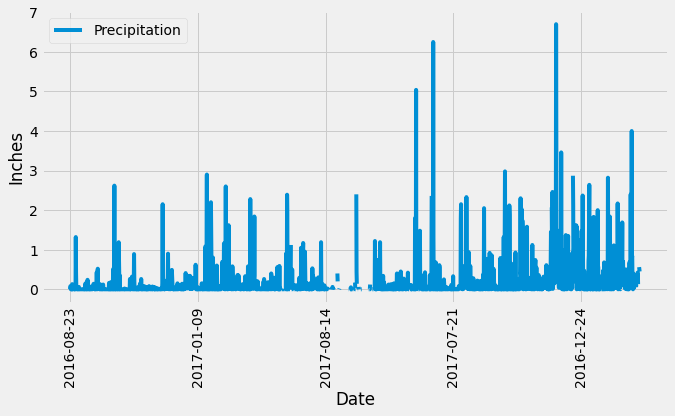

In [56]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
measurement_1year_back = dt.date(measurement_latest_year, measurement_latest_month, measurement_latest_day) - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
year_prcp = session.query(measurement.date, measurement.prcp).filter(measurement.date >= measurement_1year_back).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

year_prcp_df = pd.DataFrame(year_prcp, columns =['Date', 'Precipitation']).set_index('Date')

# Sort the dataframe by date

year_prcp_df.sort_index(axis=0)

# Use Pandas Plotting with Matplotlib to plot the data

year_prcp_df.reset_index().plot(x = 'Date', y = 'Precipitation', figsize=(10,5), rot=90)
plt.ylabel("Inches")
plt.show()


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset

stations_qty = session.query(measurement.station).distinct().count()

print(f'The total number of station in this dataset is: {stations_qty}')

The total number of station in this dataset is: 9


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations = session.query(measurement.station, func.count(measurement.station).\
                        label('count')).\
                        group_by(measurement.station).order_by(desc('count')).\
                        all()

print(f'The most active station is: {stations[0][0]}')

print('This is the list of all stations and their activity status:')

for st in stations:
    print(st.station, st.count)
    


The most active station is: USC00519281
This is the list of all stations and their activity status:
USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

TMIN = session.query(func.min(measurement.tobs)).filter(measurement.station == f'{stations[0][0]}').all()
TAVG = session.query(func.avg(measurement.tobs)).filter(measurement.station == f'{stations[0][0]}').all()
TMAX = session.query(func.max(measurement.tobs)).filter(measurement.station == f'{stations[0][0]}').all()

print(f'The temperature analysis from the most active station is:')
print(f'TMIN = {TMIN[0][0]}')
print(f'TAVG = {TAVG[0][0]}')
print(f'TMAX = {TMAX[0][0]}')
 


The temperature analysis from the most active station is:
TMIN = 54.0
TAVG = 71.66378066378067
TMAX = 85.0


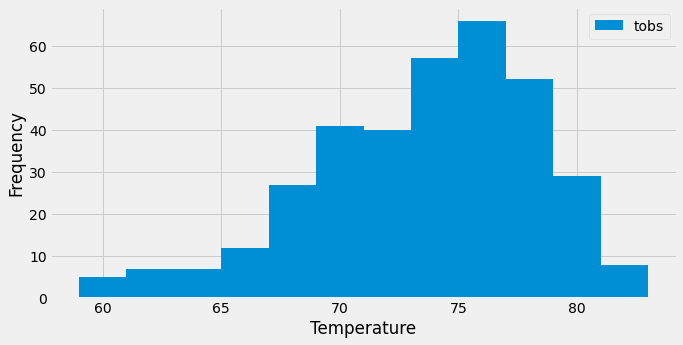

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = []
year_tobs = session.query(measurement.tobs).filter(measurement.date > measurement_1year_back).filter(measurement.station == f'{stations[0][0]}').all()

for t in year_tobs:
    temp.append(t[0])

fig, ax = plt.subplots(figsize=(10, 5))
n, bins, patches=ax.hist(temp, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.show()




# Close session

In [18]:
# Close Session
session.close()